## Some params

In [1]:
NUM_LABELS=7
LABELS=["airplane",
        "face",
        "knife",
        "motorbike",
        "other",
        "pistol",
        "NA"]
NET_NAME="net"
TRAINED_CHECKPOINT="gs://alex-s2t-test/adversarial/nets_ckpt/inception_resnet_v2_2016_08_30.ckpt"
TRANSFER_LEARNING_CHECKPOINT="gs://alex-s2t-test/adversarial/datasets/six_labels/inception_resnet/training/train/model.ckpt-1000"

## Cleanup

In [2]:
%%bash
rm -rf resources

## Setup

In [3]:
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

First, we set up the input image. We use a tf.Variable instead of a tf.placeholder because we will need it to be trainable. We can still feed it when we want to.

In [5]:
image = tf.Variable(tf.zeros((299, 299, 3)))

## Building retrained inception resnet

In [6]:
from trainer.inception_resnet_v2_builder import InceptionResnetV2Builder as ModelBuilder
modelBuilder = ModelBuilder()

In [7]:
def load_body_checkpoint(session, checkpoint_path):
    variables_to_exclude_from_scope = ModelBuilder.CHECKPOINT_VARIABLES_TO_EXCLUDE_FROM_SCOPE
    all_vars = tf.contrib.slim.get_variables_to_restore(
        exclude=variables_to_exclude_from_scope
    )

    reader = tf.train.NewCheckpointReader(checkpoint_path)
    var_to_shape_map = reader.get_variable_to_shape_map()
    inception_vars = {
        var.op.name: var
        for var in all_vars if var.op.name in var_to_shape_map
    }

    saver = tf.train.Saver(inception_vars)
    saver.restore(session, checkpoint_path)
    
def restore_head_checkpoint(session, checkpoint_path, layer1_weights, layer1_biases, layer2_weights, layer2_biases):
    var_list = {
        "InceptionResnetV2/NewLogits/fully_connected/weights" : layer1_weights,
        "InceptionResnetV2/NewLogits/fully_connected/biases" : layer1_biases,
        "InceptionResnetV2/NewLogits/fully_connected_1/weights" : layer2_weights,
        "InceptionResnetV2/NewLogits/fully_connected_1/biases" : layer2_biases
    }
    saver = tf.train.Saver(var_list=var_list)
    saver.restore(session, checkpoint_path)  

def build_head(embeddings, num_labels, scope, reuse=False):
    #print num_labels
    softmax, endpoints, ordered_endpoints = ModelBuilder().build_predict_model(embeddings, 
        num_classes=num_labels,
        final_endpoint="PreLogitsFlatten",
        final_layer_type="Softmax",
        reverse=True,
        scope=scope,
        reuse=reuse
    )
    #print softmax.get_shape().as_list()
    with tf.name_scope(scope+"/prediction"):
        prediction = tf.argmax(softmax, 1)
    
    weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
    for w in weights:
        if "fully_connected/weights" in w.name:
            fc_weights=w
        if "fully_connected/biases" in w.name:
            fc_biases=w
        if "fully_connected_1/weights" in w.name:
            fc1_weights=w
        if "fully_connected_1/biases" in w.name:
            fc1_biases=w
    
    return endpoints["Logits"], softmax, prediction, fc_weights, fc_biases, fc1_weights, fc1_biases

def build_inception_resnet(images, reuse=False):

    print("building body..")
    embeddings, end_points, ordered_end_points = modelBuilder.build_predict_model(
        images, num_classes=NUM_LABELS, final_endpoint='PreLogitsFlatten', reuse=reuse)
    
    
    weights={}

    print("building heads...")
    logits, softmax, prediction, fc_weights, fc_biases, fc1_weights, fc1_biases = build_head(
        embeddings, NUM_LABELS, NET_NAME, reuse
    )
    weights={
        "softmax":softmax,
        "prediction":prediction,
        "fc_weights":fc_weights,
        "fc_biases":fc_biases,
        "fc1_weights":fc1_weights,
        "fc1_biases":fc1_biases
    }

    outputs={}    
    w = weights

    if not reuse:
        print("loading body checkpoint...")
        load_body_checkpoint(sess, TRAINED_CHECKPOINT)
        print("loading heads checkpoints...")


        restore_head_checkpoint(
            sess, 
            TRANSFER_LEARNING_CHECKPOINT, 
            w["fc_weights"],
            w["fc_biases"],
            w["fc1_weights"],
            w["fc1_biases"]
        )
    outputs["prediction"]=w["prediction"]
    outputs["scores"]=w["softmax"]

    return logits, outputs["scores"]

In [8]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

#logits, probs = inception(image, reuse=False)

In [9]:
def inception_resnet(image, reuse=False):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    logits, probs=build_inception_resnet(preprocessed, reuse=reuse)
    return logits, probs

#logits, probs = inception_resnet(image)

In [10]:
logits, probs = inception_resnet(image)

building body..
building heads...
loading body checkpoint...
loading heads checkpoints...


In [11]:
import json
import matplotlib.pyplot as plt

In [12]:
#imagenet_json="resources/imagenet.json"
#with open(imagenet_json) as f:
#    imagenet_labels = json.load(f)

In [13]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-NUM_LABELS:][::-1])
    print(topk)
    topprobs = p[topk]
    barlist = ax2.bar(range(NUM_LABELS), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(NUM_LABELS),
               [LABELS[i] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

In [14]:
import PIL
import numpy as np

In [23]:
%%bash
wget 'https://cdn.shopify.com/s/files/1/0276/1899/products/AK-47-Assault-Rifle_large.jpg?v=1387091633' -P resources -O rifle.jpg
tar -xf resources/inception_v3_2016_08_28.tar.gz -C resources

--2018-06-19 11:06:10--  https://cdn.shopify.com/s/files/1/0276/1899/products/AK-47-Assault-Rifle_large.jpg?v=1387091633
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.194.110, 151.101.130.110, 151.101.66.110, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.194.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10086 (9.8K) [image/jpeg]
Saving to: ‘rifle.jpg’

     0K .........                                             100%  110M=0s

2018-06-19 11:06:11 (110 MB/s) - ‘rifle.jpg’ saved [10086/10086]

tar: resources/inception_v3_2016_08_28.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [24]:
img_path = 'rifle.jpg'
img_class = LABELS.index("pistol")
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

[5, 4, 1, 2, 3, 6, 0]


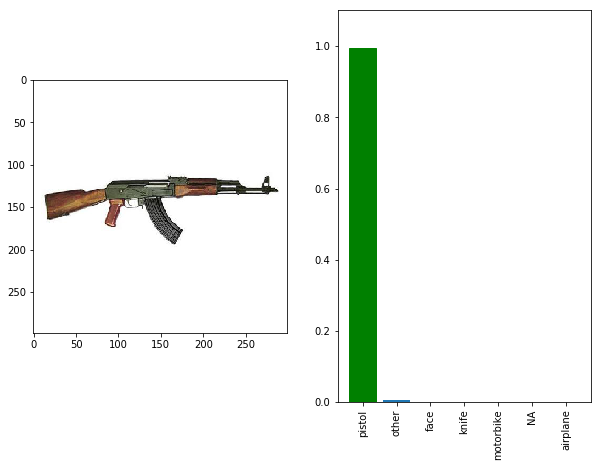

In [25]:
classify(img, correct_class=img_class)

# Adversarial examples

In [26]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

In [27]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, NUM_LABELS)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

In [28]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [29]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = LABELS.index("face")#3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=6.97632
step 20, loss=6.12238
step 30, loss=5.53996
step 40, loss=4.96149
step 50, loss=4.89916
step 60, loss=4.63727
step 70, loss=4.23188
step 80, loss=4.34671
step 90, loss=4.59212
step 100, loss=4.49482


[5, 4, 1, 2, 3, 0, 6]


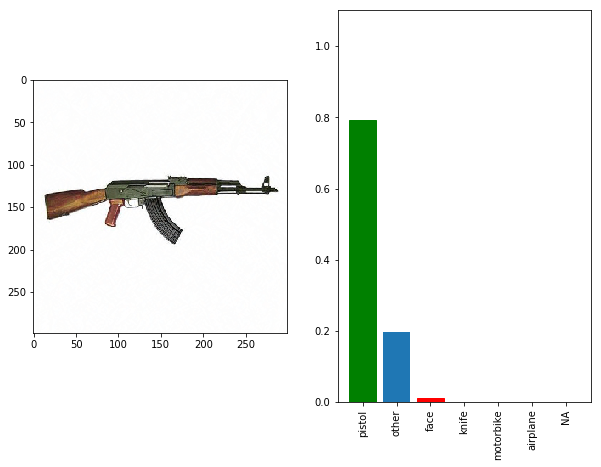

In [30]:
classify(adv, correct_class=img_class, target_class=demo_target)

In [31]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 1000
demo_target = LABELS.index("face")#3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=6.97632
step 20, loss=6.12238
step 30, loss=5.53996
step 40, loss=4.96149
step 50, loss=4.89916
step 60, loss=4.63727
step 70, loss=4.23188
step 80, loss=4.34671
step 90, loss=4.59212
step 100, loss=4.49482
step 110, loss=4.23465
step 120, loss=4.86816
step 130, loss=4.25189
step 140, loss=4.72718
step 150, loss=4.71288
step 160, loss=4.51509
step 170, loss=4.6116
step 180, loss=4.29421
step 190, loss=4.13279
step 200, loss=3.65402
step 210, loss=5.37672
step 220, loss=4.29745
step 230, loss=4.4176
step 240, loss=4.07512
step 250, loss=3.40095
step 260, loss=3.7427
step 270, loss=5.37404
step 280, loss=7.33557
step 290, loss=4.36204
step 300, loss=3.85631
step 310, loss=7.26617
step 320, loss=4.51162
step 330, loss=6.01918
step 340, loss=3.89446
step 350, loss=3.63379
step 360, loss=5.46099
step 370, loss=6.29303
step 380, loss=3.87623
step 390, loss=4.73301
step 400, loss=3.80232
step 410, loss=5.12985
step 420, loss=4.19007
step 430, loss=7.46532
step 440, loss=4.54478


[5, 4, 1, 2, 0, 3, 6]


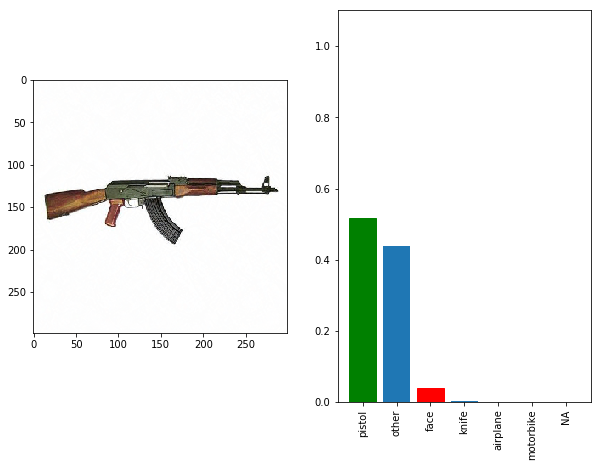

In [32]:
classify(adv, correct_class=img_class, target_class=demo_target)

# Robust adversarial examples

In [20]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

NameError: name 'adv' is not defined

In [33]:
num_samples = 10
average_loss = 0
#with tf.variable_scope("InceptionResnetV2", reuse=True):
for i in range(num_samples):
    print i
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception_resnet(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

0
building body..
building heads...
1
building body..
building heads...
2
building body..
building heads...
3
building body..
building heads...
4
building body..
building heads...
5
building body..
building heads...
6
building body..
building heads...
7
building body..
building heads...
8
building body..
building heads...
9
building body..
building heads...


In [34]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

In [35]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
#demo_steps = 300
#demo_target = 924 # "guacamole"
demo_steps = 1000
demo_target = 3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

step 50, loss=0.00699378
step 100, loss=0.00114555
step 150, loss=0.000906413
step 200, loss=0.000823416
step 250, loss=0.000393062
step 300, loss=0.000225114
step 350, loss=0.000497737
step 400, loss=0.000258964
step 450, loss=0.000219198


KeyboardInterrupt: 

In [ ]:
#adv_robust = x_hat.eval() # retrieve the adversarial example
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

## Evaluation

In [ ]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()